# NVIDIA RAPIDS on Azure ML
## MLADS Fall'19

In this notebook we use NYC Taxi dataset to showcase how to scale computations to multiple nodes on Azure ML using Dask. We will also estimate a large XGBoost model.

**AUTHORS**
* Tom Drabas (Microsoft)
* Brad Rees (NVIDIA)
* Keith Kraus (NVIDIA)
* Paul Mahler (NVIDIA)
* John Zalewski (NVIDIA)
* Chau Dang (NVIDIA)

**FURTHER TEAM**
* Joshua Patterson (NVIDIA)
* Michael Beaumont (NVIDIA)

In [1]:
from dask_cuda import LocalCUDACluster
from dask.distributed import Client

In [2]:
cluster = LocalCUDACluster()
client = Client(cluster)

In [3]:
print(client)

<Client: 'tcp://127.0.0.1:38833' processes=4 threads=4, memory=270.37 GB>


In [4]:
!nvidia-smi

Fri Nov 15 01:03:28 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.87.00    Driver Version: 418.87.00    CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  TITAN V             Off  | 00000000:03:00.0  On |                  N/A |
| 33%   49C    P2    38W / 250W |    317MiB / 12034MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  TITAN V             Off  | 00000000:04:00.0 Off |                  N/A |
| 32%   48C    P2    36W / 250W |    317MiB / 12036MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

In [7]:
import dask
import dask_cudf
import os
import socket
import dask_xgboost as dxgb
import distributed

%load_ext autotime

time: 607 µs


In [9]:
# list of column names that need to be re-mapped
remap = {}
remap['tpep_pickup_datetime'] = 'pickup_datetime'
remap['tpep_dropoff_datetime'] = 'dropoff_datetime'
remap['ratecodeid'] = 'rate_code'

#create a list of columns & dtypes the df must have
must_haves = {
    'pickup_datetime': 'datetime64[ms]',
    'dropoff_datetime': 'datetime64[ms]',
    'passenger_count': 'int32',
    'trip_distance': 'float32',
    'pickup_longitude': 'float32',
    'pickup_latitude': 'float32',
    'rate_code': 'int32',
    'dropoff_longitude': 'float32',
    'dropoff_latitude': 'float32',
    'fare_amount': 'float32'
}

# helper function which takes a DataFrame partition
def clean(df_part, remap, must_haves):    
    # some col-names include pre-pended spaces remove & lowercase column names
    tmp = {col:col.strip().lower() for col in list(df_part.columns)}
    df_part = df_part.rename(tmp)
    
    # rename using the supplied mapping
    df_part = df_part.rename(remap)
    
    # iterate through columns in this df partition
    for col in df_part.columns:
        # drop anything not in our expected list
        if col not in must_haves:
            df_part = df_part.drop(col)
            continue

        if df_part[col].dtype == 'object' and col in ['pickup_datetime', 'dropoff_datetime']:
            df_part[col] = df_part[col].astype('datetime64[ms]')
            continue
            
        # if column was read as a string, recast as float
        if df_part[col].dtype == 'object':
            df_part[col] = df_part[col].str.fillna('-1')
            df_part[col] = df_part[col].astype('float32')
        else:
            # downcast from 64bit to 32bit types
            # Tesla T4 are faster on 32bit ops
            if 'int' in str(df_part[col].dtype):
                df_part[col] = df_part[col].astype('int32')
            if 'float' in str(df_part[col].dtype):
                df_part[col] = df_part[col].astype('float32')
            df_part[col] = df_part[col].fillna(-1)
    
    return df_part

time: 7.75 ms


In [11]:
datastore = '../../notebook/intro/NYCTaxi'
data_path = os.path.join(datastore, "data/nyctaxi")

print(data_path)

dfs = []
dfs.append(dask_cudf.read_csv(os.path.join(data_path, "2016/yellow_tripdata_2016-01.csv")).map_partitions(clean, remap, must_haves))
dfs.append(dask_cudf.read_csv(os.path.join(data_path, "2016/yellow_tripdata_2016-02.csv")).map_partitions(clean, remap, must_haves))
dfs.append(dask_cudf.read_csv(os.path.join(data_path, "2016/yellow_tripdata_2016-03.csv")).map_partitions(clean, remap, must_haves))
dfs.append(dask_cudf.read_csv(os.path.join(data_path, "2016/yellow_tripdata_2016-04.csv")).map_partitions(clean, remap, must_haves))

# taxi_df_2016 = taxi_df_2016
# dfs.append(taxi_df_2016)

taxi_df = dask.dataframe.multi.concat(dfs)

../../notebook/intro/NYCTaxi/data/nyctaxi
time: 3.07 s


In [12]:
len(taxi_df)

46434197

time: 8.28 s


In [13]:
# apply a list of filter conditions to throw out records with missing or outlier values
query_frags = [
    'fare_amount > 0 and fare_amount < 500',
    'passenger_count > 0 and passenger_count < 6',
    'pickup_longitude > -75 and pickup_longitude < -73',
    'dropoff_longitude > -75 and dropoff_longitude < -73',
    'pickup_latitude > 40 and pickup_latitude < 42',
    'dropoff_latitude > 40 and dropoff_latitude < 42'
]
taxi_df = taxi_df.query(' and '.join(query_frags))

# inspect the results of cleaning
taxi_df.head().to_pandas()

,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,rate_code,dropoff_longitude,dropoff_latitude,fare_amount
0,2016-01-01,2016-01-01,2,1.10,-73.990372,40.734695,1,-73.981842,40.732407,7.5
1,2016-01-01,2016-01-01,5,4.90,-73.980782,40.729912,1,-73.944473,40.716679,18.0
2,2016-01-01,2016-01-01,1,10.54,-73.984550,40.679565,1,-73.950272,40.788925,33.0
3,2016-01-01,2016-01-01,1,4.75,-73.993469,40.718990,1,-73.962242,40.657333,16.5
4,2016-01-01,2016-01-01,3,1.76,-73.960625,40.781330,1,-73.977264,40.758514,8.0


time: 2.53 s


In [14]:
import math
from math import cos, sin, asin, sqrt, pi
import numpy as np

def haversine_distance_kernel(pickup_latitude, pickup_longitude, dropoff_latitude, dropoff_longitude, h_distance):
    for i, (x_1, y_1, x_2, y_2) in enumerate(zip(pickup_latitude, pickup_longitude, dropoff_latitude, dropoff_longitude)):
        x_1 = pi / 180 * x_1
        y_1 = pi / 180 * y_1
        x_2 = pi / 180 * x_2
        y_2 = pi / 180 * y_2
        
        dlon = y_2 - y_1
        dlat = x_2 - x_1
        a = sin(dlat / 2)**2 + cos(x_1) * cos(x_2) * sin(dlon / 2)**2
        
        c = 2 * asin(sqrt(a)) 
        r = 6371 # Radius of earth in kilometers
        
        h_distance[i] = c * r

def day_of_the_week_kernel(day, month, year, day_of_week):
    for i, (d_1, m_1, y_1) in enumerate(zip(day, month, year)):
        if month[i] < 3:
            shift = month[i]
        else:
            shift = 0
        Y = year[i] - (month[i] < 3)
        y = Y - 2000
        c = 20
        d = day[i]
        m = month[i] + shift + 1
        day_of_week[i] = (d + math.floor(m * 2.6) + y + (y // 4) + (c // 4) - 2 * c) % 7
        
def add_features(df):
    df['hour'] = df['pickup_datetime'].dt.hour
    df['year'] = df['pickup_datetime'].dt.year
    df['month'] = df['pickup_datetime'].dt.month
    df['day'] = df['pickup_datetime'].dt.day
    df['diff'] = df['dropoff_datetime'].astype('int32') - df['pickup_datetime'].astype('int32')
    
    df['pickup_latitude_r'] = df['pickup_latitude'] // .01 * .01
    df['pickup_longitude_r'] = df['pickup_longitude'] // .01 * .01
    df['dropoff_latitude_r'] = df['dropoff_latitude'] // .01 * .01
    df['dropoff_longitude_r'] = df['dropoff_longitude'] // .01 * .01
    
    df = df.drop('pickup_datetime')
    df = df.drop('dropoff_datetime')

    df = df.apply_rows(haversine_distance_kernel,
                       incols=['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude'],
                       outcols=dict(h_distance=np.float32),
                       kwargs=dict())

    df = df.apply_rows(day_of_the_week_kernel,
                       incols=['day', 'month', 'year'],
                       outcols=dict(day_of_week=np.float32),
                       kwargs=dict())


    df['is_weekend'] = (df['day_of_week']<2).astype("int32")
    return df

time: 10.2 ms


In [15]:
# actually add the features
taxi_df = taxi_df.map_partitions(add_features).persist()
done = distributed.wait(taxi_df)

# inspect the result
taxi_df.head().to_pandas()

,passenger_count,trip_distance,pickup_longitude,pickup_latitude,rate_code,dropoff_longitude,dropoff_latitude,fare_amount,hour,year,month,day,diff,pickup_latitude_r,pickup_longitude_r,dropoff_latitude_r,dropoff_longitude_r,h_distance,day_of_week,is_weekend
0,2,1.10,-73.990372,40.734695,1,-73.981842,40.732407,7.5,0,2016,1,1,0,40.730000,-74.000000,40.730000,-73.989998,0.762426,5.0,0
1,5,4.90,-73.980782,40.729912,1,-73.944473,40.716679,18.0,0,2016,1,1,0,40.719997,-73.989998,40.709999,-73.949997,3.395178,5.0,0
2,1,10.54,-73.984550,40.679565,1,-73.950272,40.788925,33.0,0,2016,1,1,0,40.669998,-73.989998,40.779999,-73.959999,12.498544,5.0,0
3,1,4.75,-73.993469,40.718990,1,-73.962242,40.657333,16.5,0,2016,1,1,0,40.709999,-74.000000,40.649998,-73.970001,7.344131,5.0,0
4,3,1.76,-73.960625,40.781330,1,-73.977264,40.758514,8.0,0,2016,1,1,0,40.779999,-73.970001,40.750000,-73.979996,2.898252,5.0,0


time: 20.8 s


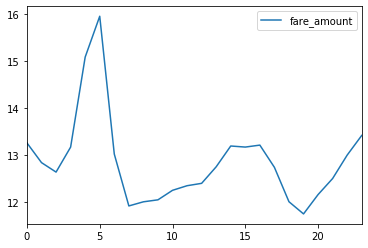

time: 4.75 s


In [16]:
%matplotlib inline
taxi_df.groupby('hour').fare_amount.mean().compute().to_pandas().sort_index().plot(legend=True)

In [17]:
X_train = taxi_df.query('day < 25').persist()

# create a Y_train ddf with just the target variable
Y_train = X_train[['fare_amount']].persist()
# drop the target variable from the training ddf
X_train = X_train[X_train.columns.difference(['fare_amount'])]

# this wont return until all data is in GPU memory
done = distributed.wait([X_train, Y_train])

time: 1.71 s


In [18]:
params = {
    'learning_rate'  : 0.3,
    'max_depth'      : 8,
    'objective'      : 'reg:squarederror',
    'subsample'      : 0.6,
    'gamma'          : 1,
    'silent'         : True,
    'verbose_eval'   : True,
    'tree_method'    :'gpu_hist'
}

trained_model = dxgb.train(client, params, X_train, Y_train, num_boost_round=100)

time: 10.9 s


In [19]:
def drop_empty_partitions(df):
    lengths = df.map_partitions(len).compute()
    nonempty = [length > 0 for length in lengths]
    return df.partitions[nonempty]

time: 1.76 ms


In [20]:
X_test = taxi_df.query('day >= 25').persist()
X_test = drop_empty_partitions(X_test)

# Create Y_test with just the fare amount
Y_test = X_test[['fare_amount']]

# Drop the fare amount from X_test
X_test = X_test[X_test.columns.difference(['fare_amount'])]

# display test set size
# len(X_test)

time: 1.85 s


In [21]:
# generate predictions on the test set
Y_test['prediction'] = dxgb.predict(client, trained_model, X_test)

time: 204 ms


In [22]:
Y_test['squared_error'] = (Y_test['prediction'] - Y_test['fare_amount'])**2

# inspect the results to make sure our calculation looks right
Y_test.head().to_pandas()

,fare_amount,prediction,squared_error
176,9.0,8.968162,0.001014
177,41.0,37.627659,11.372684
178,9.0,8.529622,0.221255
179,4.5,4.057782,0.195557
180,9.0,8.723549,0.076425


time: 570 ms


In [23]:
# compute the actual RMSE over the full test set
RMSE = Y_test.squared_error.mean().compute()
math.sqrt(RMSE)

1.9712538895267024

time: 22 s
